In [1]:
!pip install deepchem catboost rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 45.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepchem as dc
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
TARGET_INDEX = 4
SUBSET_SIZE = 20000

# Featurizer 'CoulombMatrix' автоматически создает матрицы и дополняет их нулями до макс. размера (29 атомов)
featurizer = dc.feat.CoulombMatrix(max_atoms=29)
tasks, datasets, transformers = dc.molnet.load_qm9(
    featurizer=featurizer,
    transformers=[]
)

train_dataset, valid_dataset, test_dataset = datasets

def prepare_data(dataset, limit=None):
    X = dataset.X
    y = dataset.y[:, TARGET_INDEX]

    if limit:
        X, y = X[:limit], y[:limit]

    # Кулоновская матрица от DeepChem приходит плоской (841 признак),
    # если нет - нужно сделать .reshape(len(X), -1)
    X = X.reshape(len(X), -1)
    return X, y

X_train, y_train = prepare_data(train_dataset, limit=SUBSET_SIZE)
X_test, y_test = prepare_data(test_dataset, limit=SUBSET_SIZE // 5)

In [8]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    depth=8,
    loss_function='MAE',
    verbose=100,
    random_seed=42,
    task_type="GPU"
)

In [9]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.0397546	test: 0.0398650	best: 0.0398650 (0)	total: 320ms	remaining: 10m 39s
100:	learn: 0.0328101	test: 0.0408083	best: 0.0390936 (10)	total: 13.8s	remaining: 4m 19s
200:	learn: 0.0281559	test: 0.0443858	best: 0.0390936 (10)	total: 28.6s	remaining: 4m 15s
300:	learn: 0.0259016	test: 0.0475079	best: 0.0390936 (10)	total: 43.8s	remaining: 4m 7s
400:	learn: 0.0245598	test: 0.0514348	best: 0.0390936 (10)	total: 59.3s	remaining: 3m 56s
500:	learn: 0.0234799	test: 0.0546131	best: 0.0390936 (10)	total: 1m 15s	remaining: 3m 45s
600:	learn: 0.0229069	test: 0.0572509	best: 0.0390936 (10)	total: 1m 31s	remaining: 3m 32s
700:	learn: 0.0224564	test: 0.0603532	best: 0.0390936 (10)	total: 1m 47s	remaining: 3m 19s
800:	learn: 0.0223900	test: 0.0644420	best: 0.0390936 (10)	total: 2m 4s	remaining: 3m 6s
900:	learn: 0.0219956	test: 0.0668142	best: 0.0390936 (10)	total: 2m 20s	remaining: 2m 51s
1000:	learn: 0.0219865	test: 0.0695811	best: 0.0390936 (10)	total: 2m 36s	remaining: 2m 36s
1100:	le

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae:.4f} eV")

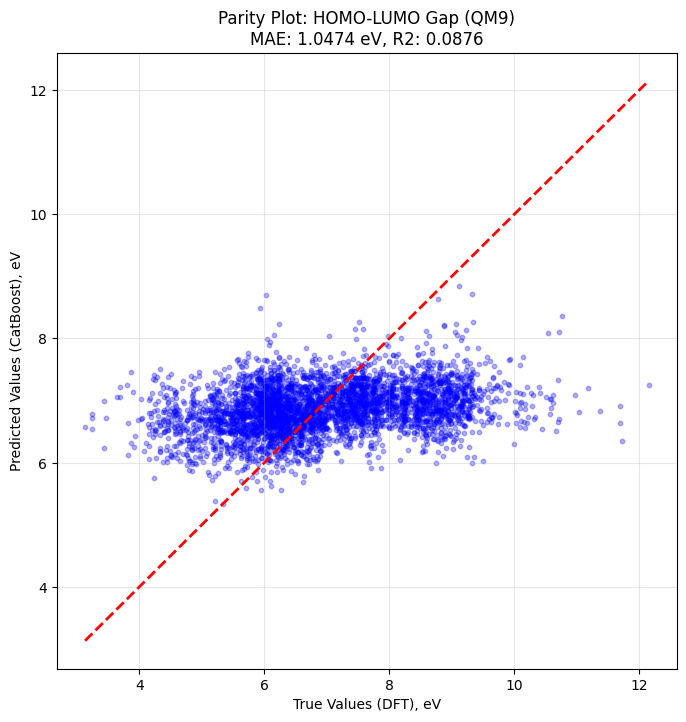

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title(f'Parity Plot: HOMO-LUMO Gap (QM9)\nMAE: {mae:.4f} eV')
plt.xlabel('True Values (DFT), eV')
plt.ylabel('Predicted Values (CatBoost), eV')
plt.grid(True, alpha=0.3)
plt.show()